<a href="https://colab.research.google.com/github/UWAGroves/HomeWork6/blob/main/HomeWork_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#Import packages and link Gdrive

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import expon
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
import xarray as xr
!pip install cartopy geoviews hvplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import hvplot.xarray
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive

drive.mount('/content/drive')

filedir = "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Import data

url = f"https://downloads.psl.noaa.gov/Datasets/ghcncams/air.mon.mean.nc"
savename = url.split("/")[-1]
urllib.request.urlretrieve(url, savename)
ds = xr.open_dataset(savename)
ds

<xarray.Dataset> Size: 960MB
Dimensions:  (lat: 360, lon: 720, time: 926)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-02-01
Data variables:
    air      (time, lat, lon) float32 960MB ...
Attributes:
    title:          NOAA/NCEP GHCN CAMS Monthly Temperature
    Conventions:    CF-1.0
    Source:         http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/....
    version:        3.01
    history:        created 8/2012 by CAS NOAA/ESRL PSDupdated to include maj...
    dataset_title:  Climate Prediction Center (CPC) Global Land Surface Air T...
    References:     https://www.psl.noaa.gov/data/gridded/data.ghcncams.html

In [10]:
#Extract the air temprature DataArray
ta = ds["air"]
ta

<xarray.DataArray 'air' (time: 926, lat: 360, lon: 720)> Size: 960MB
[240019200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-02-01
Attributes:
    long_name:      Monthly mean of surface temperature
    units:          degK
    dataset:        NOAA/NCEP GHCN CAMS
    var_desc:       Air Temperature
    level_desc:     Surface
    statistic:      Mean
    parent_stat:    Other
    standard_name:  air_temperature
    cell_methods:   time: mean
    valid_range:    [150. 400.]
    actual_range:   [-49.21874 335.75   ]

In [11]:
#Convert from K to C
ta_C = ta - 273.15

#Update attributes
ta_C.attrs["units"] = "degC"

ta_C

<xarray.DataArray 'air' (time: 926, lat: 360, lon: 720)> Size: 960MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-02-01
Attributes:
    units:    degC

In [12]:
#Select data from 1990-2020

ta_tf = ta_C.sel(time=slice("1990-01-01", "2020-12-01"))

In [13]:
#Creating weights based on area

weights = np.cos(np.deg2rad(ta_tf.lat))
weights = weights.broadcast_like(ta_tf)
weights.name = "weights"
weights


<xarray.DataArray 'weights' (time: 372, lat: 360, lon: 720)> Size: 386MB
array([[[0.00436336, 0.00436336, 0.00436336, ..., 0.00436336,
         0.00436336, 0.00436336],
        [0.0130896 , 0.0130896 , 0.0130896 , ..., 0.0130896 ,
         0.0130896 , 0.0130896 ],
        [0.02181496, 0.02181496, 0.02181496, ..., 0.02181496,
         0.02181496, 0.02181496],
        ...,
        [0.02181496, 0.02181496, 0.02181496, ..., 0.02181496,
         0.02181496, 0.02181496],
        [0.0130896 , 0.0130896 , 0.0130896 , ..., 0.0130896 ,
         0.0130896 , 0.0130896 ],
        [0.00436336, 0.00436336, 0.00436336, ..., 0.00436336,
         0.00436336, 0.00436336]],

       [[0.00436336, 0.00436336, 0.00436336, ..., 0.00436336,
         0.00436336, 0.00436336],
        [0.0130896 , 0.0130896 , 0.0130896 , ..., 0.0130896 ,
         0.0130896 , 0.0130896 ],
        [0.02181496, 0.02181496, 0.02181496, ..., 0.02181496,
         0.02181496, 0.02181496],
...
        [0.02181496, 0.02181496, 0.02181496, ..., 0.02181496,
         0.02181496, 0.02181496],
        [0.0130896 , 0.0130896 , 0.0130896 , ..., 0.0130896 ,
         0.0130896 , 0.0130896 ],
        [0.00436336, 0.00436336, 0.00436336, ..., 0.00436336,
         0.00436336, 0.00436336]],

       [[0.00436336, 0.00436336, 0.00436336, ..., 0.00436336,
         0.00436336, 0.00436336],
        [0.0130896 , 0.0130896 , 0.0130896 , ..., 0.0130896 ,
         0.0130896 , 0.0130896 ],
        [0.02181496, 0.02181496, 0.02181496, ..., 0.02181496,
         0.02181496, 0.02181496],
        ...,
        [0.02181496, 0.02181496, 0.02181496, ..., 0.02181496,
         0.02181496, 0.02181496],
        [0.0130896 , 0.0130896 , 0.0130896 , ..., 0.0130896 ,
         0.0130896 , 0.0130896 ],
        [0.00436336, 0.00436336, 0.00436336, ..., 0.00436336,
         0.00436336, 0.00436336]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
Attributes:
    actual_range:        [ 89.75 -89.75]
    long_name:           Latitude
    units:               degrees_north
    axis:                Y
    standard_name:       latitude
    coordinate_defines:  center

In [162]:
#Weighted air temps

air_weighted = ta_tf.weighted(weights)
air_weighted

weighted_mean = air_weighted.mean(("lon", "lat"))
weighted_mean

<xarray.DataArray 'air' (time: 372)> Size: 1kB
array([ 5.970686 ,  7.1851516, 11.107106 , 13.944129 , 16.876314 ,
       19.262566 , 20.154182 , 19.883478 , 17.70617  , 14.621669 ,
       10.473317 ,  7.185212 ,  6.0583477,  7.328166 ,  9.931398 ,
       13.914751 , 16.808928 , 19.372763 , 20.370842 , 19.871655 ,
       17.966867 , 14.543257 , 10.191036 ,  6.8397446,  6.3489223,
        7.398067 , 10.179305 , 13.386293 , 16.601274 , 18.789707 ,
       19.62703  , 19.372862 , 17.243198 , 14.006326 ,  9.57056  ,
        7.0351944,  6.0854287,  7.2382746, 10.161078 , 13.47436  ,
       16.750237 , 18.978046 , 20.12994  , 19.640676 , 17.404118 ,
       14.31236  ,  9.406825 ,  7.072537 ,  5.875866 ,  6.321281 ,
       10.092463 , 13.823732 , 16.946222 , 19.266865 , 20.20539  ,
       19.782673 , 17.940222 , 14.744226 , 10.460703 ,  7.20223  ,
        6.5737505,  8.196803 , 10.25244  , 13.885322 , 16.884605 ,
       19.430738 , 20.38205  , 20.29327  , 18.16326  , 14.959263 ,
       10.552278 ,  7.026081 ,  5.7563195,  7.3648853,  9.752321 ,
       13.301132 , 16.92881  , 19.060522 , 20.26768  , 19.776274 ,
       17.613556 , 14.295063 , 10.174981 ,  7.2361293,  6.07345  ,
        7.3524623, 10.303459 , 13.753403 , 16.773785 , 19.322744 ,
       20.374537 , 20.048609 , 18.16118  , 14.877888 , 10.389222 ,
        7.2806315,  6.2659326,  8.291188 , 10.473856 , 14.458402 ,
...
        7.010741 ,  6.562768 ,  7.88138  , 10.632093 , 14.028038 ,
       17.489065 , 19.836035 , 20.745947 , 20.351665 , 18.411535 ,
       15.1762295, 11.233901 ,  7.7160544,  6.6935244,  7.22826  ,
       10.943884 , 14.562238 , 17.593554 , 19.848728 , 20.820543 ,
       20.622925 , 18.509306 , 15.31013  , 10.669913 ,  8.1562395,
        6.8998947,  8.205224 , 11.161107 , 14.35538  , 17.627054 ,
       20.050016 , 20.99376  , 20.875996 , 18.910814 , 15.653848 ,
       11.371662 ,  8.682778 ,  7.2303042,  9.106269 , 12.012642 ,
       15.150258 , 17.737904 , 20.08768  , 21.17677  , 20.947834 ,
       18.900322 , 15.112517 , 10.99055  ,  7.9191236,  7.225822 ,
        8.51537  , 11.423062 , 14.651247 , 17.61444  , 19.913666 ,
       21.069653 , 20.817703 , 18.756481 , 15.36615  , 10.95739  ,
        8.245099 ,  6.7694435,  7.880072 , 11.020566 , 14.491164 ,
       17.51879  , 19.781635 , 21.100307 , 20.542809 , 18.609644 ,
       15.505428 , 10.758705 ,  7.94878  ,  7.032534 ,  8.097006 ,
       11.512991 , 14.91421  , 17.729044 , 20.24093  , 21.123896 ,
       20.74148  , 19.011444 , 15.811776 , 11.201644 ,  8.528729 ,
        7.630905 ,  8.941493 , 11.677226 , 14.791674 , 17.7335   ,
       20.044058 , 21.149048 , 20.80939  , 19.021278 , 15.56719  ,
       11.719244 ,  8.03486  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01

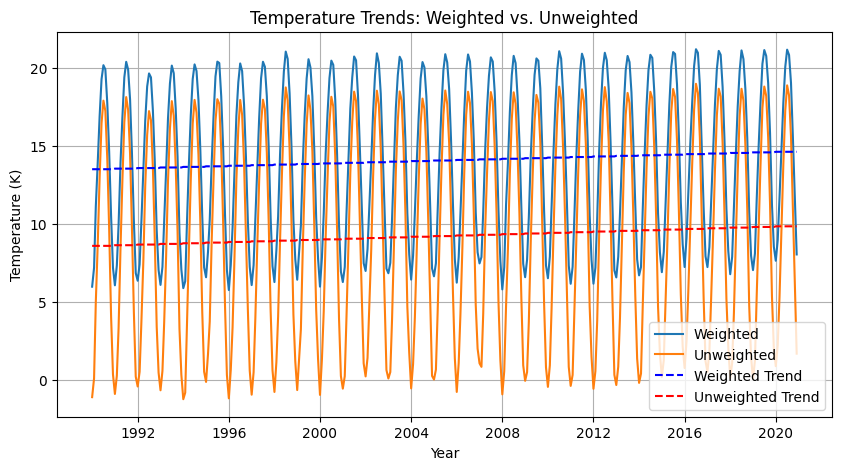

In [161]:
#Extract years
years = weighted_mean["time"].dt.year  # Ensure time is in years

#Linear regression for weighted mean
slope_w, intercept_w, _, _, _ = linregress(years, weighted_mean)
trend_w = slope_w * years + intercept_w

#Linear regression for unweighted mean
unweighted_mean = ta_tf.mean(("lon", "lat"))  # Compute spatial mean
slope_u, intercept_u, _, _, _ = linregress(years, unweighted_mean)
trend_u = slope_u * years + intercept_u  # Compute trend line values

#Plot mean temps
plt.figure(figsize=(10, 5))
weighted_mean.plot(label="Weighted")
unweighted_mean.plot(label="Unweighted")

#Plot trend lines
plt.plot(weighted_mean.time, trend_w, linestyle="--", color="blue", label=f"Weighted Trend")
plt.plot(unweighted_mean.time, trend_u, linestyle="--", color="red", label=f"Unweighted Trend")

plt.xlabel("Year")
plt.ylabel("Temperature (K)")
plt.title("Temperature Trends: Weighted vs. Unweighted")
plt.legend()
plt.grid()

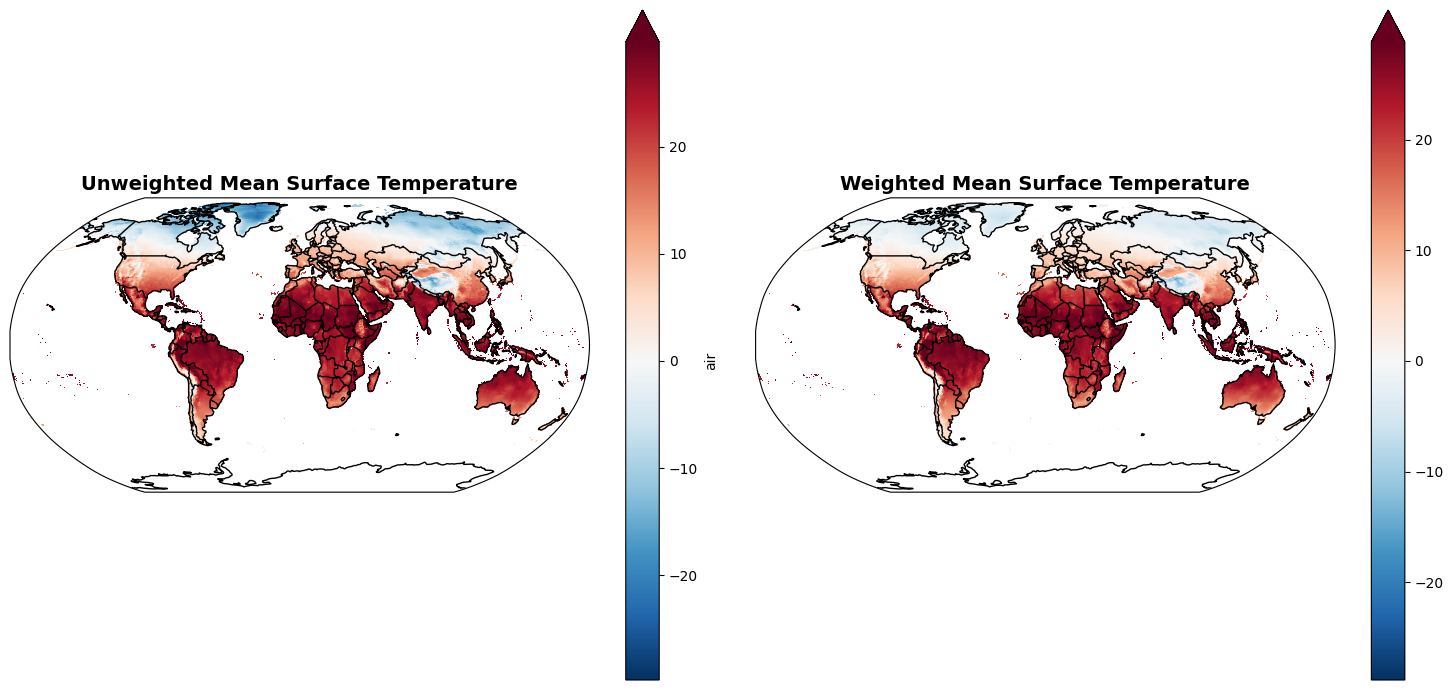

In [22]:
#Create fig
fig, axes = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': ccrs.Robinson()})

#Plot unweighted mean temp
ta_tf.sel().mean(dim="time").plot(
    ax=axes[0],  # Plot on the first subplot
    transform=ccrs.PlateCarree(),
    robust=True,
    facecolor="gray"
)
axes[0].set_title("Unweighted Mean Surface Temperature", fontsize=14, fontweight="bold")
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS)

#Plot weighted mean temp
Weighted_Map = ta_tf * weights
Weighted_Map.sel().mean(dim="time").plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    robust=True,
    facecolor="gray",
)
axes[1].set_title("Weighted Mean Surface Temperature", fontsize=14, fontweight="bold")
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS)

plt.tight_layout()
plt.show()